# Tutorial: Numerical solution of optimal control problems governed by the Laplace equation 

Before we begin let

$$
% \DeclareMathOperator{\Div}{div}
% \DeclareMathOperator{\Grad}{grad}
% \DeclareMathOperator{\Curl}{curl}
% \DeclareMathOperator{\Rot}{rot}
% \DeclareMathOperator{\ord}{ord}
% \DeclareMathOperator{\Kern}{ker}
% \DeclareMathOperator{\Image}{im}
% \DeclareMathOperator{\spann}{span}
% \DeclareMathOperator{\dist}{dist}
% \DeclareMathOperator{\diam}{diam}
% \DeclareMathOperator{\sig}{sig}
\newcommand{\RR}{\mathbb{R}}
\newcommand{\NN}{\mathbb{N}}
\newcommand{\VV}{\mathbb{V}}
\newcommand{\dGamma}{\,\mathrm{d} \Gamma}
\newcommand{\dGammah}{\,\mathrm{d} \Gamma_h}
\newcommand{\dx}{\,\mathrm{d}x}
\newcommand{\dy}{\,\mathrm{d}y}
\newcommand{\ds}{\,\mathrm{d}s}
\newcommand{\dt}{\,\mathrm{d}t}
\newcommand{\dS}{\,\mathrm{d}S}
\newcommand{\dV}{\,\mathrm{d}V}
\newcommand{\dX}{\,\mathrm{d}X}
\newcommand{\dY}{\,\mathrm{d}Y}
\newcommand{\dE}{\,\mathrm{d}E}
\newcommand{\dK}{\,\mathrm{d}K}
\newcommand{\dM}{\,\mathrm{d}M}
\newcommand{\cd}{\mathrm{cd}}
\newcommand{\onehalf}{\frac{1}{2}}
\newcommand{\bfP}{\boldsymbol P}
\newcommand{\bfx}{\boldsymbol x}
\newcommand{\bfa}{\boldsymbol a}
\newcommand{\bfu}{\boldsymbol u}
\newcommand{\bfv}{\boldsymbol v}
\newcommand{\bfe}{\boldsymbol e}
\newcommand{\bfg}{\boldsymbol g}
\newcommand{\bfb}{\boldsymbol b}
\newcommand{\bff}{\boldsymbol f}
\newcommand{\bfp}{\boldsymbol p}
\newcommand{\bft}{\boldsymbol t}
\newcommand{\bfj}{\boldsymbol j}
\newcommand{\bfB}{\boldsymbol B}
\newcommand{\bfV}{\boldsymbol V}
\newcommand{\bfE}{\boldsymbol E}
\newcommand{\bfK}{\boldsymbol K}
\newcommand{\mcT}{\mathcal{T}}
\newcommand{\mcL}{\mathcal{L}}
\newcommand{\mcU}{\mathcal{U}}
\newcommand{\ubar}{\overline{u}}
\newcommand{\ybar}{\overline{y}}
\newcommand{\pbar}{\overline{p}}
$$




In this notebook we solve numerically the distributed optimal control problem

\begin{align*}
J(y, u) = \dfrac{1}{2} \| y - y_{\Omega}\|_{\Omega}^2 + \dfrac{\gamma}{2} \| u \|^2_{\Omega} \to \min
\end{align*}

subject to state equation
\begin{alignat}{2}
-\Delta y &= f + \beta u & &\quad \text{in } \Omega,
\\
        y &= 0 & & \quad \text{on } \Gamma = \partial \Omega, 
\end{alignat}
and $u \in \mathcal{U}_{ad}$  for some convex subset of $\mathcal{U} = L^2(\Omega)$. Here,
$\beta $ is simply some positive constant, and for simplicity, we pick $\Omega = (0,1)^2 \subset \mathbb{R}^2$. 

Finally, our target function is 
$$y_{\Omega} = 10x_1(1-x_1)x_2(1-x_2).
$$.
This example is take from [ManzoniQuarteroniSalsa2021, Section 6.5.1, Test case 1](https://link.springer.com/10.1007/978-3-030-77226-0).

In [ ]:
op = AffineFEOperator(a, l, Vd, V0)
yh  = solve(op)
ydiff = yh - yΩ

writevtk(Ω, "results", cellfields=["y"=> yh, "yOmega"=>yΩ, "ydiff" => ydiff])

## Problem 1

Let $\mathcal{U}_{ad} = \mathcal{U}$ and solve the resulting *unconstrained* OCP numerically by implementing a descent methods using
  * steepest descent as descent direction
  * backtracking Armijo line-search to select the step length

  Choose
  $$ 
  \rho = \dfrac{1}{2},
  \quad
  \alpha_0 = 1.0,
  \quad 
  \alpha_{\mathrm{min}} = 0.01,
  \quad 
  \gamma = 10^{-4},
  \quad
  N_{\max} = 500  
$$

We present a detailed step-by-step walk-through of the s. Afterwards, we will wrap up everything and encapsulated our code into a nice and neat solver function.  


## Step 1

First, we need to derive the adjoint equation and the optimality condition, and we will do so using the formal Lagrange method.
For the given state equation and and cost functional, the Lagrangian $\mathcal{L}(y,u,p)$ is given by
$$
\mcL(y, u, p) = J(y, u) - a(y,p) + (f + \beta u, p)_{\Omega}.
$$


So we want to find $\ubar, \ybar, \pbar$ such that
\begin{align*}
\mcL'_p(\ybar,\ubar,\pbar) \phi &= -a(\ybar, \varphi) + (f + \beta \ubar, \varphi)_{\Omega} = 0 \quad \forall \varphi \in V
\\
\mcL'_y(\ybar,\ubar,\pbar) \psi &=  J'_y(\ybar,\ubar) \psi -a(\psi, \pbar) = (\ybar - y_{\Omega}, \psi)_{\Omega} - a(\psi, \pbar) = 0 \quad \forall \psi \in V 
\\
\mcL'_u(\ybar,\ubar,\pbar) v &=  J'_u(\ybar,\ubar)+ (\beta v, \pbar)_{\Omega}
\\
&= (\ubar, v)_{\Omega} + (\beta v, \pbar)_{\Omega}
=(\ubar + \beta \pbar, v)_{\Omega} = 0 \quad \forall v \in \mathcal{U}.
\end{align*}


Setting $u_0$, $\sigma, \rho$, $\tau$, $\tau_{\mathrm{min}}$

## Step 2 Pseudocode for the Descent method with Armijo backtracking

Before we start implementing, let's have a look at the following pseudocode taking from 
[ManzoniQuarteroniSalsa2021, Algorithm 6.2](https://link.springer.com/book/10.1007/978-3-030-77226-0) 

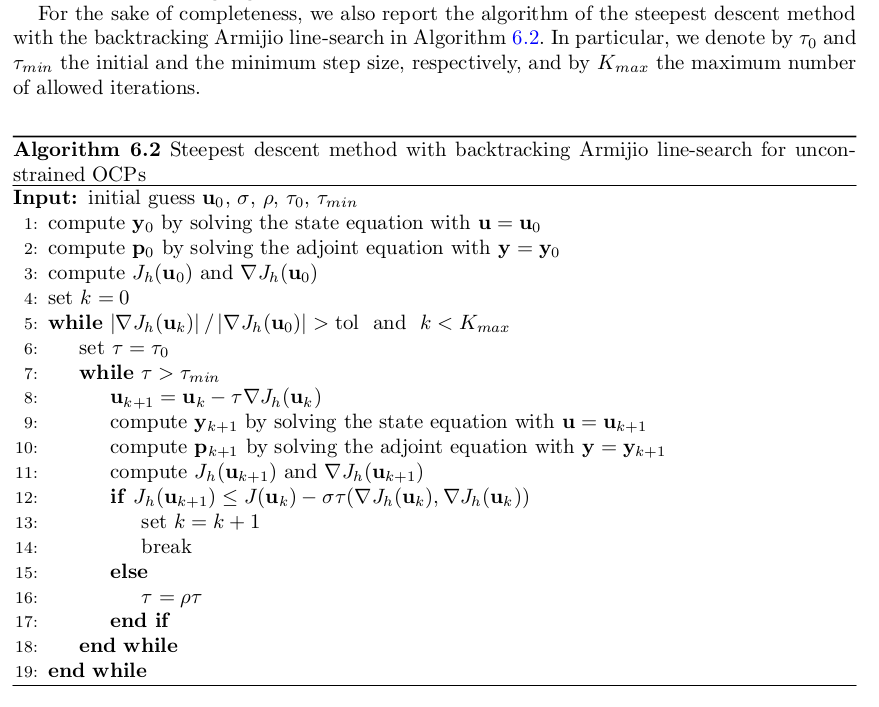

* Discuss how you would realize the computation of $J(u_{k+1})$ and $\nabla J(u_{k+1})$ in practice
* Can you find any flaws in the given pseudocode? How could you improve it?
* Which parts remain unchanged when you solve the state and co-state problems for different controls $u$ and states $y$? 
  How can we use this to reduce the computational time for each state/co-state solve?

## Step 3 Review of how to solve PDEs problems in Gridap 

As a little refresher, we now implement the state problem for an initial random control $u$.
At the same time, we will see how to make the state/co-state  

In [2]:
using Gridap
domain = (0,1,0,1)
partition = (50, 50)
model = CartesianDiscreteModel(domain, partition) |> simplexify
writevtk(model, "mesh_nx$(partition[1])_ny$(partition[2])")

#
β = 1
f = 0
yΩ(x) = 10*x[1]*(1-x[1])*x[2]*(1-x[2]) # Target function
yd(x) = 0  # Dirichlet condition

## Define function spaces 
order = 1
reffe = ReferenceFE(lagrangian, Float64, order)

# Test and trial spaces for the state problem
V0 = TestFESpace(model, reffe, conformity=:H1, dirichlet_tags="boundary")
Vd = TrialFESpace(V0, yd)

# Function space for the control
U = FESpace(model, reffe, conformity=:H1)

# Set up measures
degree = 2*order
Ω = Triangulation(model)
dΩ = Measure(Ω, degree)

# Define lhs for state problem
a(y,φ) = ∫(∇(y)⋅∇(φ))*dΩ
# Define lhs for state problem
# As the control u will change throughout the numerical computation
# make l dependent on u as well.
# Later we use lambda function to make a concrete l in each step, e.g.
# l_u = φ -> l(φ, u)
l(φ, u) = ∫((f+β*u)*φ)*dΩ

# Generate a random u
u_dof_vals = rand(Float64, num_free_dofs(U))
u = FEFunction(U, u_dof_vals)
l_u(φ) = l(φ, u)

op = AffineFEOperator(a, l_u, Vd, V0)
y  = solve(op)
ydiff = y - yΩ

writevtk(Ω, "results", cellfields=["y"=> y, "yOmega"=>yΩ, "ydiff" => ydiff])

(["results.vtu"],)

Now we modify the code above to make multiple solves with same lhs but different rhs more efficient. We will need the following snippets
```julia
# Assemble a and l manually
A = assemble_matrix(a, Vd, V0)
b = assemble_vector(l, V0)

# Use a AffineOperator (NOT an AffineFEOperator) to work on linear system directly
using Gridap.Algebra
op = AffineOperator(A, b)
lu = LUSolver()

# Solve system manually, store the cached LU decomposition
y_dof_vals  = fill(10.0, num_free_dofs(V0))
cache solve!(y_dof_vals, lu, op)
y = FEFunction(V0, y_dof_vals)

# A subsequent solve would look like this
cache solve!(y_dof_vals, lu, op, cache, false)
```


#### Task

Incorporate the suggested changes in the code above.
Time the solve of the equation twice using the `@time` macro 

In [ ]:
Next we now implement the descent method

In [ ]:

## Define l2 norms and cost functional
l2(g) = sum(∫(g*g)*dΩ)^0.5
# Good to know/mind variable scope: Note that J depends implicitly on γ. If you change γ, so will J!
γ = 10^-6
J(y,u) = 1/2*sum(∫((y-yΩ)*(y-yΩ))*dΩ) + γ/2*sum(∫(u*u)*dΩ)

## Set-up co-state problem similar as we did for the state problems

##

# Define gradient function for
∇J(u, p) = (γ*u + β*p)


# Parameters for the descent methods
ρ, α_0, α_min, σ, K_max, tol = 1/2, 1.0, (1/2)^5, 10^-4, 2000, 10^-3


Now we everything set up, let's implement the descent method which we want to call like this
```julia
descent_method(a=a, l=l, astar=astar, lstar=lstar, spaces=(Vd, V0, U), J=J, ∇J=∇J,
               ρ=ρ, α_0=α_0, α_min=α_min, σ=σ, K_max=K_max, tol=tol)
```

In [ ]:
function descent_method(;a, l, astar, lstar, spaces, J, ∇J,
                         ρ, α_0, α_min, σ, K_max, tol)
    ## Step 1 Initialization 

    # Extract spaces
    Vd, V0, U = spaces

    # Initialize u with some random values
    u_dof_vals = rand(Float64, num_free_dofs(U))
    u = FEFunction(U, u_dof_vals)

    # Assemble lhs/rhs for state equation
    A = ...
    b = ...

    ## Now solve the state problem, but cache the LU decomposition!
    ...
    ...
    y = FEFunction(Vd, y_dof_vals)
    ydiff = y - yΩ


    # Assemble lhs/rhs
    # Note that we have Dirchlet b.c. y = 0 so Vd == V!
    Astar = ...
    bstar = ...

    ## Now solve the co-state problem, but cache the LU decomposition 
    ...
    ...
    p = FEFunction(V0, p_dof_vals)

    # Initial solve of state problem
    writevtk(Ω, "results_intial", cellfields=["y"=> y, "yOmega"=>yΩ, "ydiff" => ydiff, "u" => u, "p" => p])

    # Store copies for iteration
    u_old = FEFunction(U, get_free_dof_values(u))
    y_old = FEFunction(V0, get_free_dof_values(y))
    cost_old = J(y_old, u_old)
    println("Initial cost J(y, u) = $(cost_old)")

    # Compute initial gradient
    Jgrad =  ∇J(u, p)
    # Compute initial descent direction
    dk = - Jgrad
    # Compute norm of initial gradient
    l2_Jgrad_0 = l2(Jgrad)

    ## Step 2: Run iteration
    k = 1 
    while k <= K_max && l2(Jgrad) > tol*l2_Jgrad_0
        println("========================================")
        println("Iteration Step k = $(k)")
        # Make sure that cost variable is defined outside of backtracking loop
        cost = cost_old

        # Start backtracking
        α = α_0
        while α > α_min
            println("----------------------------------------")
            println("Step length alpha = $(α)")
            # Compute tentative new control function defined by current line search parameter
            u = interpolate(u_old + α*dk, U)

            # Compute corresponding state problem by reassembling rhs l and solve linear system using the cached LU decomposition
            ...
            ...

            # Compare decrease in functional and accept if sufficient
            cost = ...
            println(" J(y_old, u_old) = $(cost_old)")
            println(" J(y, u) = $(cost)")
            if cost < cost_old + σ*α*sum(∫(Jgrad*dk)*dΩ)
                break
            else
                α *= ρ
            end
        end

        # Store latest control and state and resulting cost for next iteration
        ...
        ...

        # Now Compute new gradient and descent direction via new adjoint state
        ...
        ...
        k += 1
    end     

    ydiff = y - yΩ
    writevtk(Ω, "results_final", cellfields=["y"=> y, "yOmega"=>yΩ, "ydiff" => ydiff, "u" => u, "p" => p])
end